# BE - Semantic Segmentation
## A Salt Identification Case Study

https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

Le but de la segmentation sémantique d'images est d'étiqueter chaque pixel d'une image avec une classe correspondante de ce qui est représenté. Comme nous prédisons pour chaque pixel de l'image, cette tâche est communément appelée prédiction dense.

L'output elle-même est une image haute résolution (généralement de la même taille que l'image d'entrée) dans laquelle chaque pixel est classé dans une classe particulière. Il s'agit donc d'une classification d'image au niveau du pixel.

# Business problem - TGS

TGS est l'une des principales entreprises de géosciences et de données qui utilise des images sismiques et des rendus 3D pour comprendre les zones situées sous la surface de la Terre qui contiennent de grandes quantités de pétrole et de gaz.

Il est intéressant de noter que les surfaces qui contiennent du pétrole et du gaz contiennent également d'énormes dépôts de sel. Ainsi, à l'aide de la technologie sismique, ils essaient de prédire quelles zones de la surface de la Terre contiennent d'énormes quantités de sel.

Malheureusement, l'imagerie sismique professionnelle nécessite une vision humaine experte pour identifier exactement les corps salins. Cela conduit à des rendus très subjectifs et variables. En outre, si la prédiction humaine est incorrecte, les compagnies pétrolières et gazières peuvent subir des pertes considérables. Le TGS a donc organisé un concours Kaggle, afin d'utiliser la vision artificielle pour résoudre cette tâche avec une efficacité et une précision accrues.

# Import

In [1]:
import cv2
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy import ndimage
import pandas as pd
import numpy as np
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras import layers, Model
from keras.layers import Dropout, Input
from tensorflow.keras import layers
from PIL import Image
import glob
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
rng = np.random.default_rng()
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import itertools
np.random.seed(1) # pour que l'exécution soit déterministe

In [2]:
# tf.test.gpu_device_name()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive') 


# Sommaire

[I. Loading and exploring data](#Partie1) 

[II. UNET Architecture and Training](#Partie2)
- [II.1. Architecture definition](#Partie2.1)
- [II.2. Training](#Partie2.2)

[III. Inference](#Partie3)
- [III.1. Training set](#Partie3.1)
- [III.2. testing set](#Partie3.2)

[IV. Questions](#Partie4)
- [IV.1. Max pooling](#Partie4.1)
- [IV.2. Skip Connections](#Partie4.2)
- [IV.3. FCN and Auto-encoder](#Partie4.3)
- [IV.4. Threshold for inference](#Partie4.4)


## I. Loading and exploring data<a class="anchor" id="Partie1"></a>

In [4]:
path=r"C:/Users/thiba/OneDrive/Documents/GitHub/Keras_Pytorch_Tensorflow/keras/Semantic segmentation/"
path_img=r"C:/Users/thiba/OneDrive/Documents/GitHub/Keras_Pytorch_Tensorflow/keras/Semantic segmentation/tgs-salt-identification-challenge/train/images/"
path_mask=r"C:/Users/thiba/OneDrive/Documents/GitHub/Keras_Pytorch_Tensorflow/keras/Semantic segmentation/tgs-salt-identification-challenge/train/masks/"

In [5]:
#path=r"/content/drive/MyDrive/train/"
#path_img=r"/content/drive/MyDrive/train/train/images/"
#path_mask=r"/content/drive/MyDrive/train/train/masks/"

In [6]:
def pre_process(L,resize_factor):
    new_L=[]
    for img in L:
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, resize_factor), mode = 'constant', preserve_range = True)
        new_L.append(x_img/255)
    return new_L


In [7]:
image_list = []
for filename in glob.glob(path_img+'*.png'): # for png images
    im=cv2.imread(filename,cv2.IMREAD_COLOR)
    im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    image_list.append(im)

In [8]:
masks_list = []
for filename in glob.glob(path_mask+'*.png'): # for png images
    im=cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    masks_list.append(im)

In [9]:
def visualisation(X, y,ix=None):
    """Function to plot the results"""
    if ix==None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[ix], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Salt true')

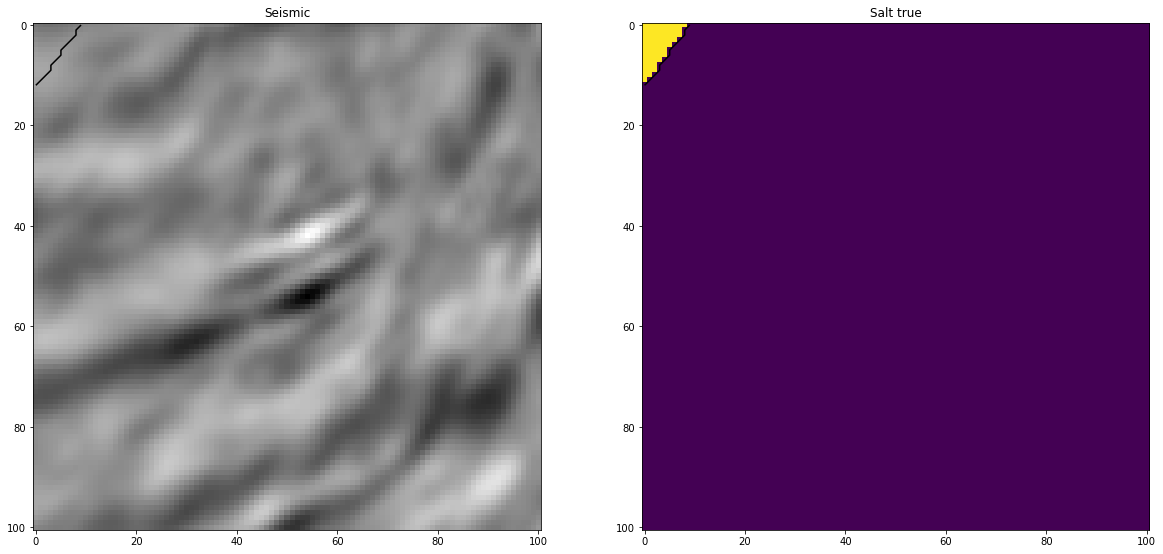

In [10]:
visualisation(image_list,masks_list,ix=None)

On comprend ici assez vite pourquoi il est complex de de distinguer les zones avec des corps salins de celle sans corps salin. Il n'y a pas de pattern évident à l'oeil...

In [11]:
# Split train and valid
masks_list=pre_process(masks_list,1)
image_list=pre_process(image_list,3)
img_train, img_test, mask_train, mask_test = train_test_split(image_list, masks_list, test_size=0.4, random_state=42)

In [12]:
img_train=np.asarray(img_train)
img_test=np.asarray(img_test)
mask_train=np.asarray(mask_train)
mask_test=np.asarray(mask_test)

On a ici construit les sets de train et de test pour l'entraînement de notre UNET.

## II. UNET Architecture and Training<a class="anchor" id="Partie2"></a>

### II.1. Architecture definition<a class="anchor" id="Partie2.1"></a>

Ci dessous une première fonction pour définir les blocks de 2 couches convolutionnelles avec les mêmes paramètres.

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

Ci-dessous on définit l'architecture complète de U-NET qui est donc de type encoder-decoder avec une étape de downsampling (encoder) pour capter toutes l'information dans l'image d'entrée. Et une séconde étape de upsampling (decoder) pour redonner une image de même résolution que l'originale avec un "label" donné à chacun des pixels de cette image.   

In [14]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
im_width = 128
im_height = 128
input_img = Input((im_height, im_width, 3), name='img')
# Build model
model = get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

On vient ici de correctement initialiser notre UNET en vérifiant que chaque couche correspond au schéma attendu dans l'énoncé. 

On identifie bien la partie **Encoder** qui est la partie de **downsampling**:
 - input: image 128x128x3
 - output image 8x8x256

Puis on retrouve la partie **Decoder** qui est la partie de **upsampling**:
 - input image 8x8x256
 - output: image 128x128x1

### II.2. Training<a class="anchor" id="Partie2.2"></a>

On définit ci-dessus les callbacks pour l'entraînement de notre U-NET afin d'optimiser l'apprentissage et de sauvegarder le meilleur modèle.

In [16]:
my_callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(path+'model-tgs.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

#### Training avec 5 epochs

In [17]:
results = model.fit(img_train, mask_train, batch_size=32, epochs=5,validation_data=(img_test, mask_test),callbacks=my_callbacks)

Epoch 1/5
75/75 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8152
Epoch 00001: val_loss improved from inf to 7.61786, saving model to C:/Users/thiba/OneDrive/Documents/GitHub/Keras_Pytorch_Tensorflow/keras/Semantic segmentation\model-tgs.h5
75/75 [==============================] - 212s 3s/step - loss: 0.4135 - accuracy: 0.8152 - val_loss: 7.6179 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 2/5
75/75 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8652
Epoch 00002: val_loss improved from 7.61786 to 1.22009, saving model to C:/Users/thiba/OneDrive/Documents/GitHub/Keras_Pytorch_Tensorflow/keras/Semantic segmentation\model-tgs.h5
75/75 [==============================] - 234s 3s/step - loss: 0.3232 - accuracy: 0.8652 - val_loss: 1.2201 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 3/5
75/75 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8767
Epoch 00003: val_loss did not improve from 1.22009
75/75 [=======================

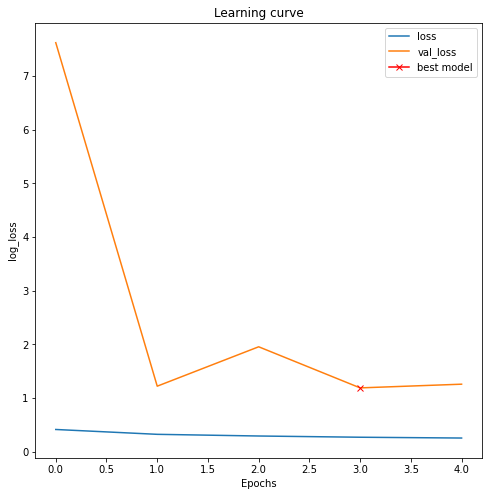

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

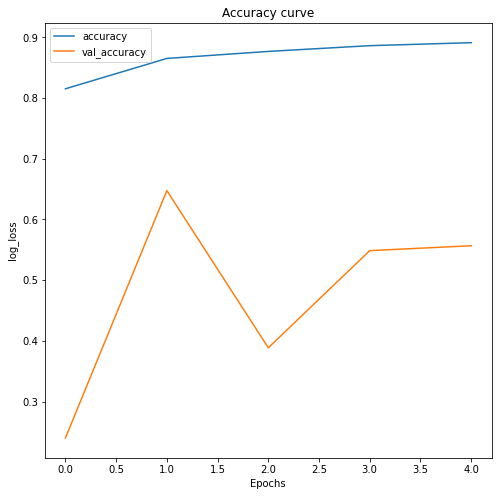

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

Avec ces 2 graphiques ci-dessus on peut voir comment le modèle apprend afin de diminuer sa loss et ce qui a pour conséquence d'améliorer grandement sa précision.

#### Training avec 50 epochs

In [20]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
im_width = 128
im_height = 128
input_img = Input((im_height, im_width, 3), name='img')
# Build model
model = get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [21]:
results = model.fit(img_train, mask_train, batch_size=32, epochs=30,validation_data=(img_test, mask_test),callbacks=my_callbacks)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8234
Epoch 00001: val_loss did not improve from 1.18818
75/75 [==============================] - 233s 3s/step - loss: 0.4072 - accuracy: 0.8234 - val_loss: 2.6907 - val_accuracy: 0.3370 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.8669
Epoch 00002: val_loss did not improve from 1.18818
75/75 [==============================] - 243s 3s/step - loss: 0.3171 - accuracy: 0.8669 - val_loss: 4.4988 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.8773
Epoch 00003: val_loss did not improve from 1.18818
75/75 [==============================] - 263s 4s/step - loss: 0.2958 - accuracy: 0.8773 - val_loss: 1.5371 - val_accuracy: 0.5170 - lr: 0.0010
Epoch 4/30
75/75 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.8743
Epoch 00004: val_loss did not improve from

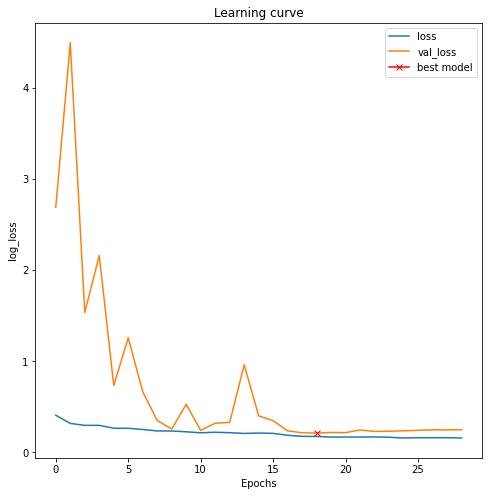

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

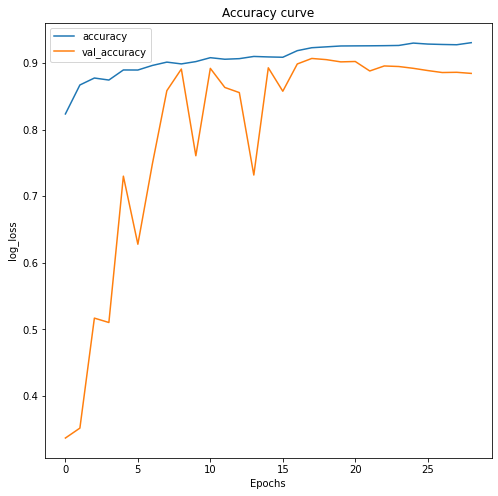

In [23]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

## III. Inference<a class="anchor" id="Partie3"></a>

In [24]:
model.load_weights(path+'model-tgs.h5')

In [25]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(img_test, mask_test, verbose=1) 

50/50 [==============================] - 32s 646ms/step - loss: 0.2113 - accuracy: 0.9049


[0.21134817600250244, 0.9049389362335205]

In [26]:
# Predict on train, val and test
preds_train = model.predict(img_train, verbose=1)
preds_val = model.predict(img_test, verbose=1)

50/50 [==============================] - 32s 650ms/step


In [27]:
# Threshold predictions
threshold=0.5
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

Les performances de l'algorithme sur le jeu de validation sont donc une accuracy de plus de 90% ce qui est très satisfaisant pour une solution "brute" sans fine tunning.

Il pourrait être intéressant de fine tunner le paramètre de seuil ci-dessus pour obtenir le meilleur possible pour avoir l'image binaire la plus informative en optimisant pour ne pas perdre d'information mais ne pas en inclure trop non plus nous verrons cela dans la question 4 plus bas. 

In [28]:
def full_visualisation(X, y, preds, binary_preds,ix=None):
    """Function to plot the results"""
    if ix==None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Salt true')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary')

### III.1. Training set<a class="anchor" id="Partie3.1"></a>

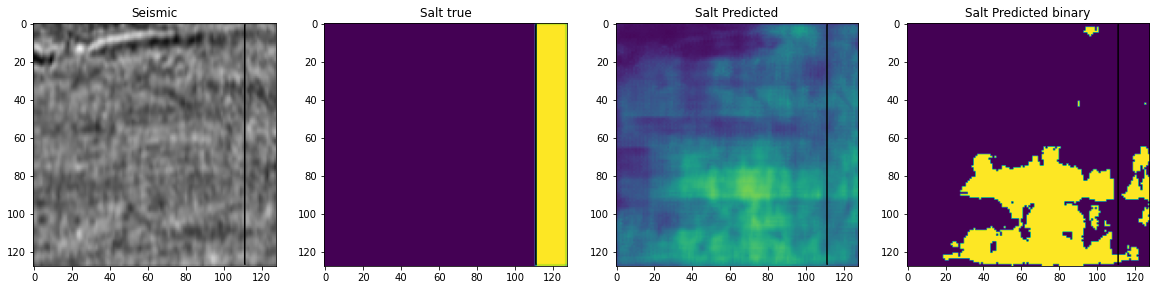

In [29]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=None)

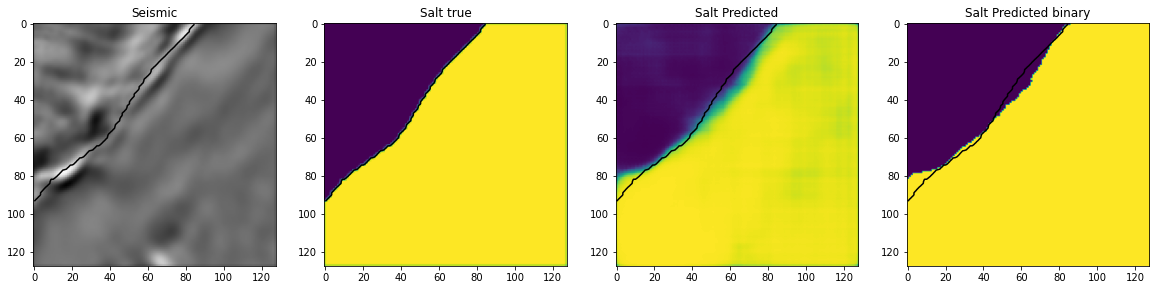

In [30]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=None)

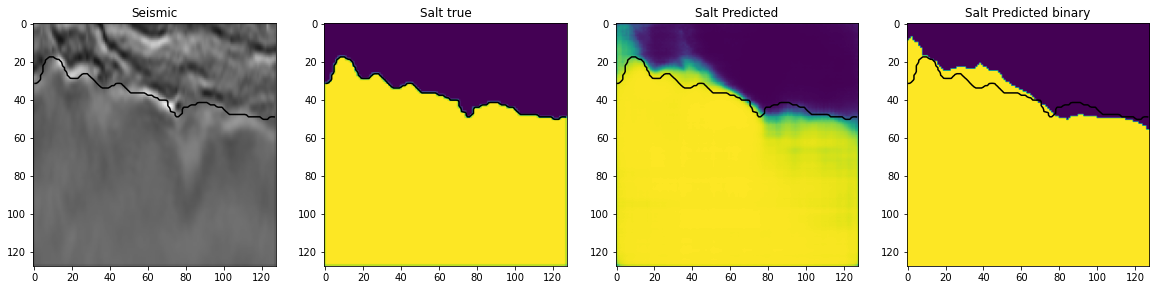

In [143]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=None)

On remarque sur le jeu de train des prédictions correct mais qui pourrait petre amélioré notamment sur les prédictions binaires en jouant sur le seuil de binarisation.

### III.2. Test set<a class="anchor" id="Partie3.2"></a>

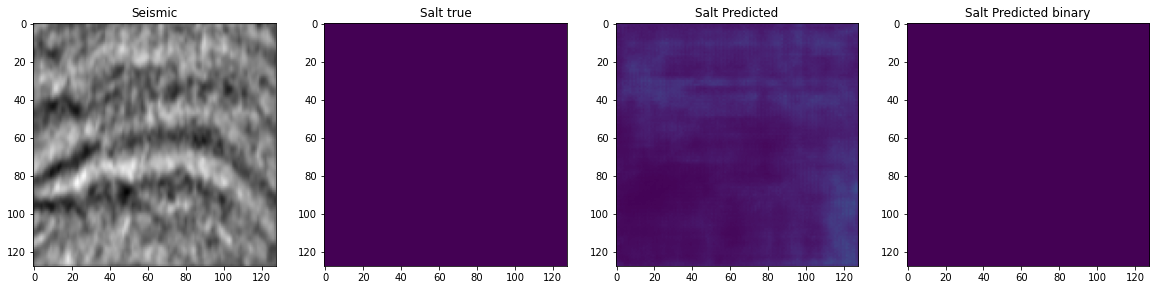

In [32]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=None)

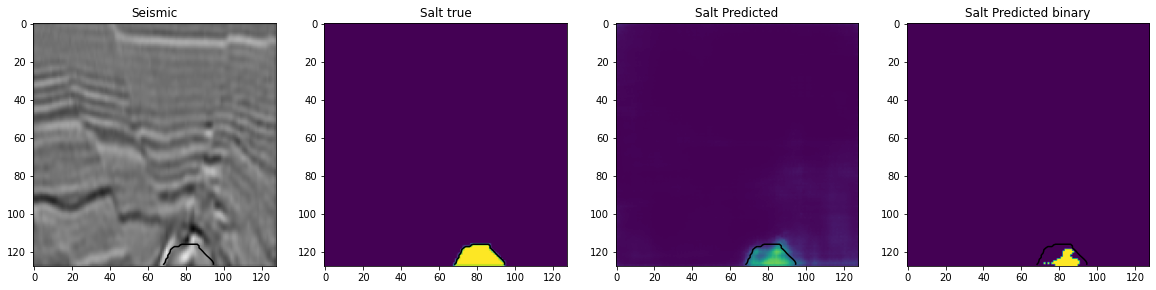

In [144]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=None)

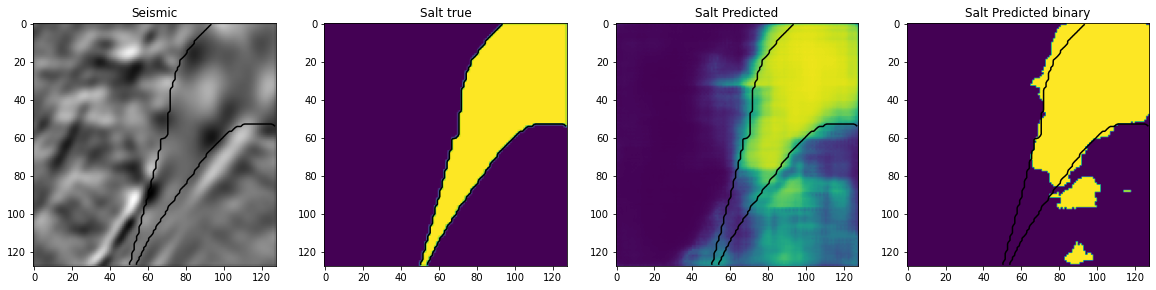

In [151]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=None)

On voit que sur le jeu de validation les prédictions bien que correctes ont l'air plus approximatives ce qui peut être du pour 2 raisons: problème de généralisation de l'algorithme et donc un sur-apprentissage du set de train dans l'entraînement de l'algorithme ou bien un manque d'échantillon dans le set d'entraînement (ce qui est plausible car 4000 images en tout n'est pas un nombre très important d'image pour arriver à un eprédiction optimale).

## IV. Questions<a class="anchor" id="Partie4"></a>

### IV.1. Max pooling<a class="anchor" id="Partie4.1"></a>

La fonction du pooling est de réduire la taille de la carte des caractéristiques afin d'avoir moins de paramètres dans le réseau.

L'idée est de ne retenir que les caractéristiques importantes (pixels de valeur maximale) de chaque région et de rejeter les informations qui ne sont pas importantes. Par important, on entend l'information qui décrit le mieux le contexte de l'image.

on reprogramme la définition de l'architecture du Unet sans Max Pooling cette fois-ci mais en ajoutant un pas (stride) de 2.

In [35]:
def conv2d_block_maxpooling(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),strides=(2, 2),
                kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [36]:
def get_unet_maxpooling(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block_maxpooling(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block_maxpooling(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block_maxpooling(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block_maxpooling(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block_maxpooling(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [37]:
im_width = 128
im_height = 128
input_img = Input((im_height, im_width, 3), name='img')
# Build model
model_maxpool = get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True)
model_maxpool.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model_maxpool.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 128, 128, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [38]:
results_maxpool = model_maxpool.fit(img_train, mask_train, batch_size=32, epochs=15,validation_data=(img_test, mask_test))

Epoch 1/15
75/75 [==============================] - 257s 3s/step - loss: 0.4821 - accuracy: 0.7819 - val_loss: 12.8701 - val_accuracy: 0.2455
Epoch 2/15
75/75 [==============================] - 239s 3s/step - loss: 0.3349 - accuracy: 0.8631 - val_loss: 2.5691 - val_accuracy: 0.3710
Epoch 3/15
75/75 [==============================] - 237s 3s/step - loss: 0.3021 - accuracy: 0.8757 - val_loss: 2.9716 - val_accuracy: 0.4657
Epoch 4/15
75/75 [==============================] - 235s 3s/step - loss: 0.2762 - accuracy: 0.8854 - val_loss: 0.9048 - val_accuracy: 0.7033
Epoch 5/15
75/75 [==============================] - 252s 3s/step - loss: 0.2730 - accuracy: 0.8859 - val_loss: 0.7444 - val_accuracy: 0.7563
Epoch 6/15
75/75 [==============================] - 252s 3s/step - loss: 0.2623 - accuracy: 0.8874 - val_loss: 0.4080 - val_accuracy: 0.8234
Epoch 7/15
75/75 [==============================] - 242s 3s/step - loss: 0.2408 - accuracy: 0.8972 - val_loss: 0.4013 - val_accuracy: 0.8376
Epoch 8/15
7

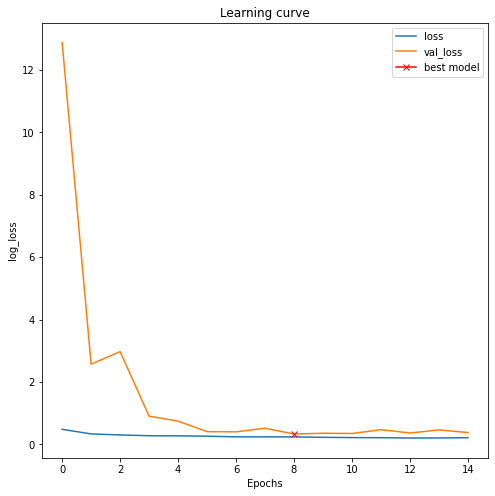

In [39]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results_maxpool.history["loss"], label="loss")
plt.plot(results_maxpool.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_maxpool.history["val_loss"]), np.min(results_maxpool.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

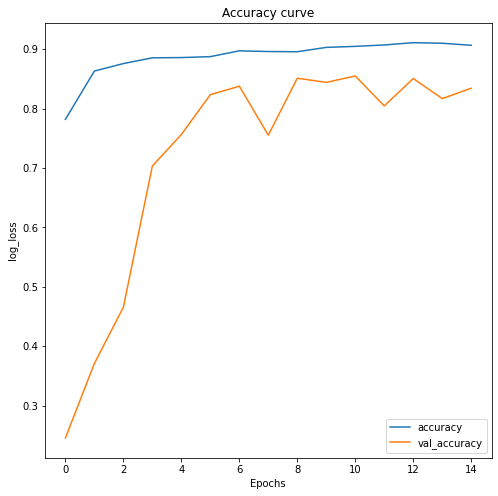

In [40]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy curve")
plt.plot(results_maxpool.history["accuracy"], label="accuracy")
plt.plot(results_maxpool.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

In [41]:
model_maxpool.evaluate(img_test, mask_test, verbose=1) 

50/50 [==============================] - 40s 796ms/step - loss: 0.3792 - accuracy: 0.8342


[0.37922343611717224, 0.8341578841209412]

On voit ici en retirant les couches de MaxPool et en utilisant un stride 2 on obtient une accuracy sur le set de test plus faible qu'avec la méthode avec les MaxPool (83% VS 90%)

### IV.2. Skip Connections<a class="anchor" id="Partie4.2"></a>

En utilisant une Skip Connections, on fournit un chemin alternatif pour le gradient (avec la backpropagation). Ces chemins supplémentaires sont souvent bénéfiques pour la convergence du modèle. Les Skip Connections dans les architectures profondes, comme leur nom l'indique, sautent une couche du réseau neuronal et alimentent la sortie d'une couche comme entrée des couches suivantes (au lieu de la seule suivante). 

Dans notre cas avec le UNET les Skip Connections sont utilisées pour faire passer les caractéristiques du chemin du codeur au chemin du décodeur afin de récupérer les informations spatiales perdues lors du sous-échantillonnage. En introduisant des Skip Connections dans l'architecture encodeur-décodeur, des détails peuvent être récupérés dans la prédiction pour bien obtenir une image en sortie qui est liée à l'image d'entrée.

Si on retire les Skip Connections cela aurait pour résultats de décorelés l'image d'entrée et de sortie on obtiendrait donc pas (ou du moins il faudrait un entraînement beaucoup plus long) une image de sortie similaire avec à l'image d'entrée ce qui est problématique dans le cas de la segmentation on veut retrouver toutes les portions de l'image d'entrée avec "simplement" une couleur attribuée à chaque pixel de l'image d'origine correpondant à la classe prédite de ce pixel. 

Dans le cas du UNET on utilise une concatenation pour effectuer le processus de Skip Connections cependant dans d'autres structure ce n'est pas la solution privilégiée et on peut envisager d'utiliser une addition / min / max. (https://theaisummer.com/skip-connections/)

Pour une architecture type ResNet on va avoir tendance à privilégier une addition de l'input d'une couche à son output afin que lors de la backpropagation on évite le problème du gradient vanishing étant donnée qu'à chaque block ce gradient sera donc multiplié par un plus le gradient de la couche en question. Cependant dans  notre cas il n'y a pas d'intérèt à utiliser max min ou une addition car cela nous ferait alors perdre le "contexte" de l'image d'entrée que l'on souhaite amener à l'image de sortie dans la phase de upsampling

### IV.3. FCN and Auto-encoder<a class="anchor" id="Partie4.3"></a>

Un autoencodeur (ie une strucutre encoder-decoder) est un réseau de neurones qui tente de régénérer l'entrée en tant que sortie en créant un goulot d'information au milieu, qui peut être utilisé comme une représentation dense de l'entrée. Notre autoencoder ici consiste donc à réduire l'image d'entrée pour en comprendre le contexte le plus précis puis à la regrossir afin d'obtenir l'image segmentée en sortie.

Avec un Fully Convolutionnal Layer on fait traverser l'image à travers une série de couche convolutionnelle de même taille. Cette solution me semble envisageable bien qu'elle sera extrêmement contraignante d'un point de vu entrainement car il y a aura énormément de paramètre à mettre à jour (beaucoup plus que dans l'architecture encoder-decoder) étant donnée que chaque couche de convolution aura des filtres de la taille de l'image et donc énormément de paramètres avec.

### IV.4. Threshold for inference<a class="anchor" id="Partie4.4"></a>

Nous avons définit un seuil de 0.5 pour binariser les images. Cela signifie que tout pixel avec une valeur strictement supérieure à 0.5 sera blanc sinon il sera noir (on crée un masque à partir des images prédites). Mais un choix de seuil manuel de cette manière n'est pas très optimal comme on peut le voir sur les résultats suivants: en prenant la même image et en faisant varier le seuil de 0.1 à 0.9 avec des pas de 2 on obtient une image binaire prédite complètement différente.

In [123]:
# Predict on train, val and test
preds_train = model.predict(img_train, verbose=1)
preds_val = model.predict(img_test, verbose=1)

50/50 [==============================] - 34s 679ms/step


#### Threshold = 0.1

In [124]:
# Threshold predictions
threshold=0.1
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

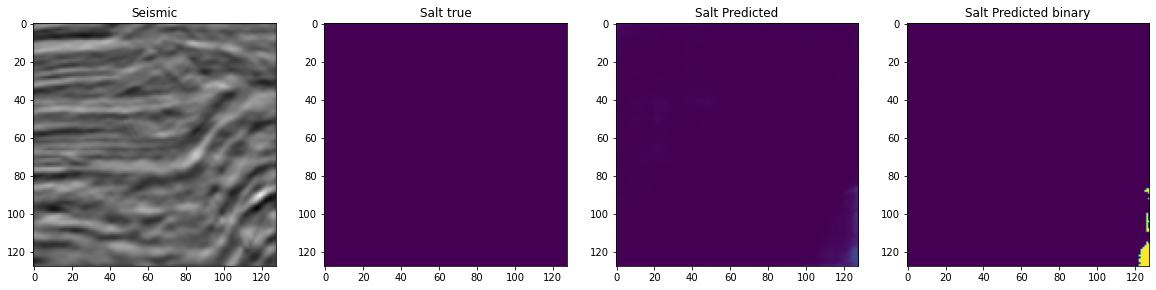

In [125]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=7)

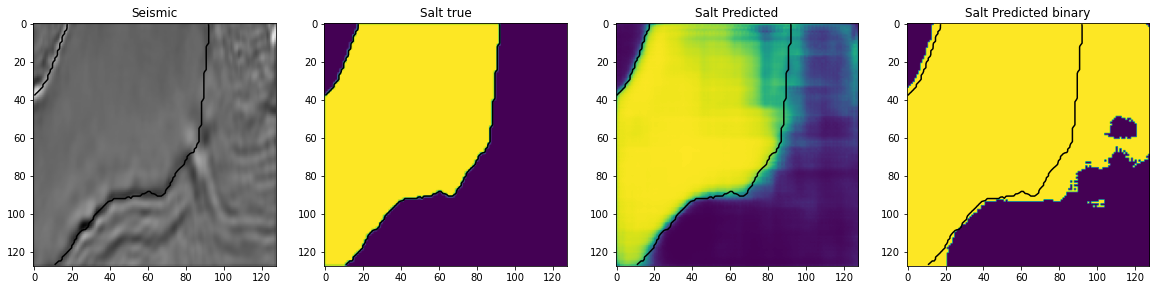

In [126]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=23)

#### Threshold = 0.3

In [127]:
# Threshold predictions
threshold=0.3
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

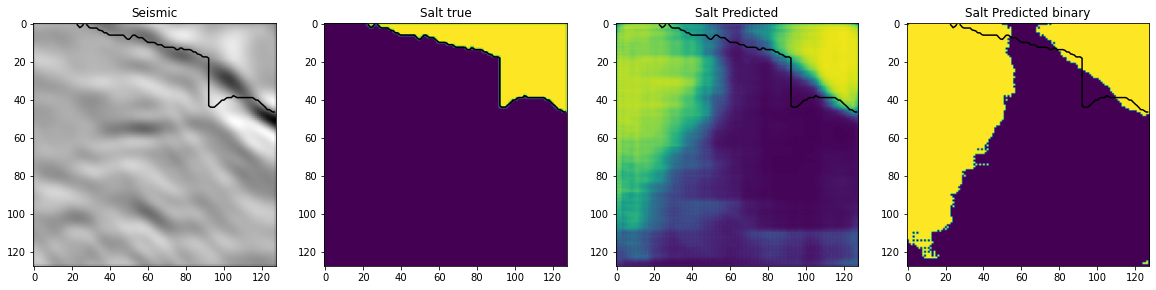

In [128]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=17)

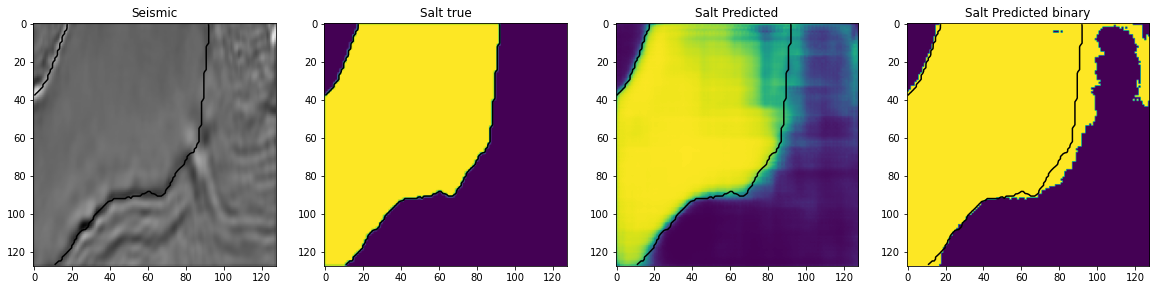

In [129]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=23)

#### Threshold = 0.5

In [130]:
# Threshold predictions
threshold=0.5
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

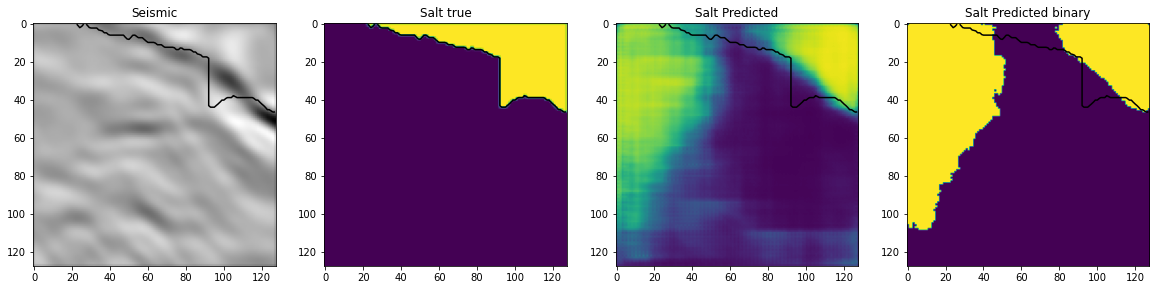

In [131]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=17)

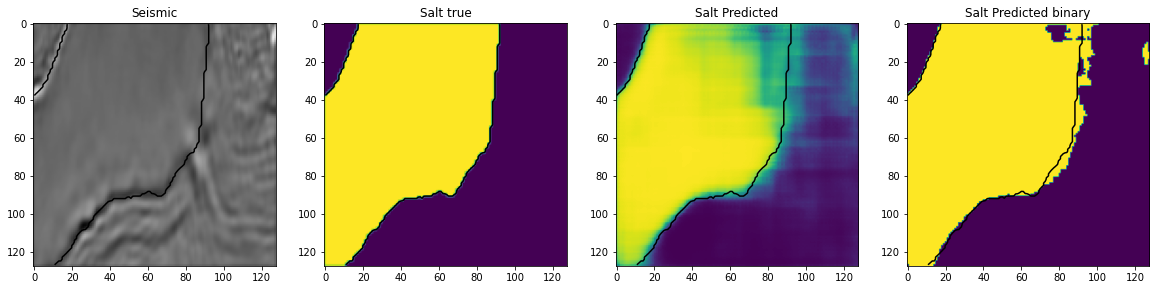

In [132]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=23)

#### Threshold = 0.7

In [133]:
# Threshold predictions
threshold=0.7
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

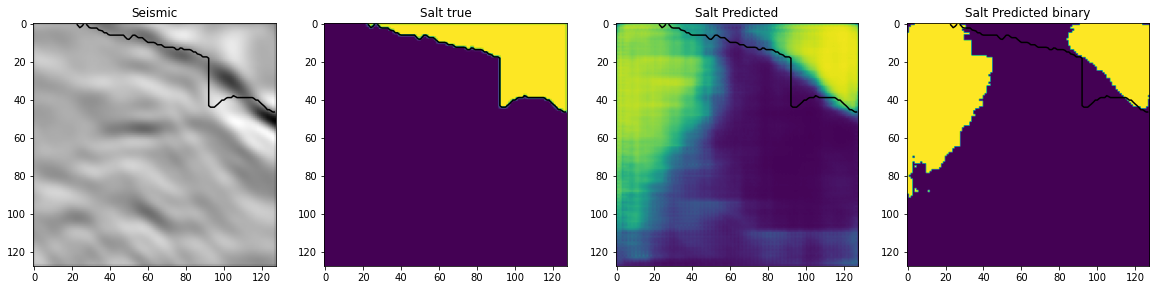

In [134]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=17)

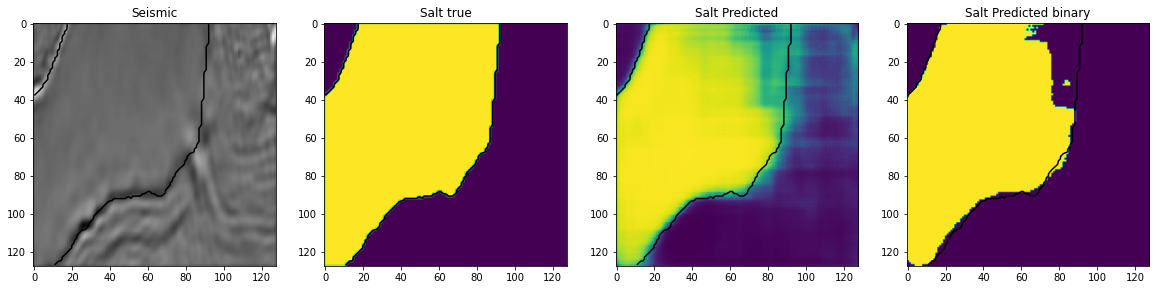

In [135]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=23)

#### Threshold = 0.9

In [136]:
# Threshold predictions
threshold=0.9
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

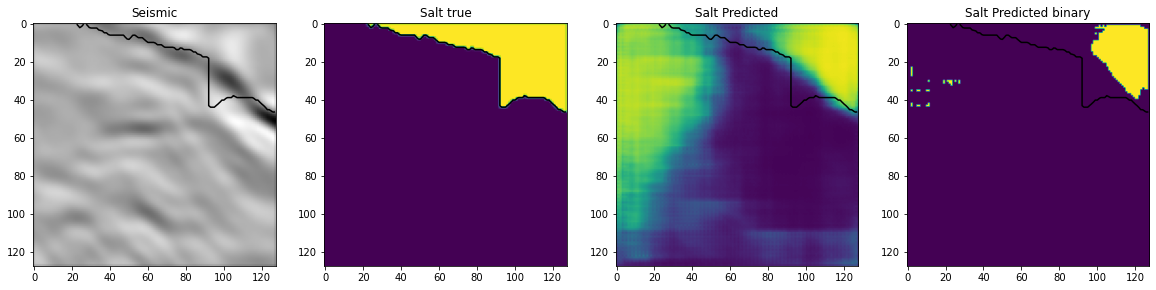

In [137]:
# Check if training data looks all right
full_visualisation(img_train, mask_train, preds_train, preds_train_t, ix=17)

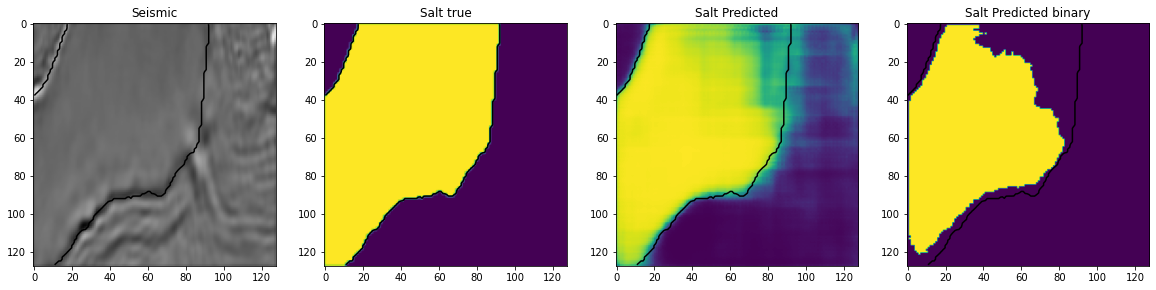

In [138]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=23)

On peut voir à travers ces exemples qu'en utilisant un seuil différent pour une même image nous allons obtenir des résultats complètement différent sur l'image binariser et donc l'enjeu de détermination du seuil otpimal est extrêmement important.

Une stratégie qui pourrait être envisagée pour obtenir un seuil correct pour binariser une image serait d'utiliser les histogrammes de distribution de couleur (ici de nuance de gris qui renvoie donc la distribution des pixels de chaque couleur de 0 à 1 présent dans l'image) dans les images prédites du set de validation. 

On peut imaginer prendre l'histogramme moyen des prédictions du set de validation et choisir à partir de cette histogramme le seuil entre 0 et 1 qui permet de conserver les informations importantes et de conserver notamment uniquement les segmetations de zones salines repérées (du fait de la moyenne sur tous les histogrammes on va permttre d'avoir moins de bruit sur l'histogramme pltôt qu'en prenant un unique histogramme pour choisir le seuil pour toutes les images).

In [139]:
histogram, bin_edges = np.histogram(preds_val[23], bins=256, range=(0.0, 1.0))

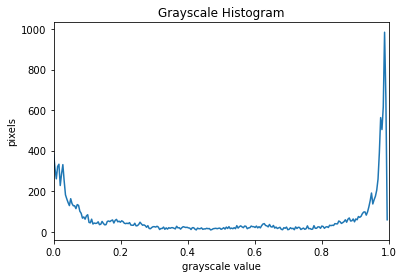

In [140]:
plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)
plt.show()

Pour la segmentation de l'image du set de validation que l'on souhaite prédire ci-dessus on peut voir ici qu'un seuil optimal serait probablement aux environs de 0.6 afin de retirer tous les pixels précédents de trop faible intensité ne contenant pas d'information et pour garder le pic d'intensité juste après 0.6 qui contient probablement de l'information sur la segmentation.

In [141]:
# Threshold predictions
threshold=0.6
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)

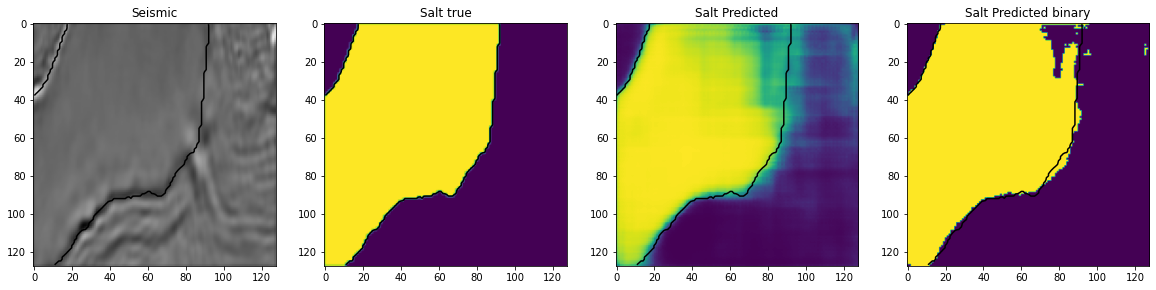

In [142]:
# Check if valid data looks all right
full_visualisation(img_test, mask_test, preds_val, preds_val_t, ix=23)